In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from tabulate import tabulate
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, accuracy_score, f1_score, normalized_mutual_info_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.io import loadmat
import scipy

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def mat_to_df(chemin):
  mat = loadmat(chemin)
  if scipy.sparse.issparse(mat['W']):
    return {'X' : pd.DataFrame(mat['fea']), 
          'labels': pd.DataFrame(mat['gnd']),
          'matrice_adjacence' : pd.DataFrame(mat['W'].toarray())}

  return {'X' : pd.DataFrame(mat['fea']), 
          'labels': pd.DataFrame(mat['gnd']),
          'matrice_adjacence' : pd.DataFrame(mat['W'])}


def print_scores(classifier, x_test, y_test):
  y_pred = classifier.predict(x_test)

  acc = round(accuracy_score(y_test, y_pred), 3)
  f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
  nmi = round(normalized_mutual_info_score(list(y_test), y_pred), 3)

  print(f"Accuracy  : {acc}")
  print(f"F1 score  : {f1}")
  print(f"NMI score : {nmi}")

  return [acc, f1, nmi]

# Données crédits bancaires

**Contexte**

L'ensemble de données de crédits décrit les détails financiers et bancaires des
clients et la tâche consiste à déterminer si le client est bon ou mauvais. L'hypothèse
est que la tâche consiste à prédire si un client remboursera un prêt ou un crédit.
L'ensemble de données comprend 1000 exemples et 20 variables, dont 7
numériques (entiers) et 13 catégorielles :

* Statut du compte courant existant

* Durée en mois

* Historique de crédit

* Objectif

* Montant du crédit

* Compte d'épargne

* Emploi actuel depuis

* Taux de versement en pourcentage du revenu disponible

* Statut personnel et sexe

* Autres débiteurs

* Résidence actuelle depuis

* Propriété

* Age en années

* Autres plans de versement

* Logement

* Nombre de crédits existants dans cette banque

* Travail

* Nombre de personnes à charge

* Téléphone

* Travailleur étranger

## Importation des données

### Importation du jeu de données

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
df = read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


Les variables catégorielles utilisent des codes. Pour mieux comprendre le jeu de données lors de la phase d'exploration, on les remplace par leurs vraies valeurs.


In [ ]:
headers=["Status of existing checking account",\
         "Duration in month","Credit history",\
         "Purpose","Credit amount",\
         "Savings account/bonds",\
         "Present employment since",\
         "Installment rate in percentage of disposable income",\
         "Personal status and sex",\
         "Other debtors / guarantors",\
         "Present residence since",\
         "Property",\
         "Age in years",\
         "Other installment plans",\
         "Housing","Number of existing credits at this bank",\
         "Job","Number of people being liable to provide maintenance for",\
         "Telephone","foreign worker",\
         "Risk"]

df.columns=headers

Status_of_existing_checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df["Status of existing checking account"]=df["Status of existing checking account"].map(Status_of_existing_checking_account)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df["Credit history"]=df["Credit history"].map(Credit_history)

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df["Purpose"]=df["Purpose"].map(Purpose)

Saving_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df["Savings account/bonds"]=df["Savings account/bonds"].map(Saving_account)

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df["Present employment since"]=df["Present employment since"].map(Present_employment)

Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
df["Personal status and sex"]=df["Personal status and sex"].map(Personal_status_and_sex)

Other_debtors_guarantors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df["Other debtors / guarantors"]=df["Other debtors / guarantors"].map(Other_debtors_guarantors)

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df["Property"]=df["Property"].map(Property)

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df["Other installment plans"]=df["Other installment plans"].map(Other_installment_plans)

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df["Housing"]=df["Housing"].map(Housing)

Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df["Job"]=df["Job"].map(Job)

Telephone={'A192':"yes", 'A191':"none"}
df["Telephone"]=df["Telephone"].map(Telephone)

foreign_worker={'A201':"yes", 'A202':"no"}
df["foreign worker"]=df["foreign worker"].map(foreign_worker)

risk={1:"Good Risk", 2:"Bad Risk"}
df["Risk"]=df["Risk"].map(risk)

df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Risk
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,4,real estate,67,none,own,2,skilled employee / official,1,yes,yes,Good Risk
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad Risk
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good Risk
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,4,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good Risk
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad Risk


### Description des données

In [ ]:
# shape
df.shape

(1000, 21)

Le jeu de données décrit 1000 individus avec 20 variables explicatives. Il y a également une variable à expliquer. 

In [ ]:
# types
df.dtypes

Status of existing checking account                         object
Duration in month                                            int64
Credit history                                              object
Purpose                                                     object
Credit amount                                                int64
Savings account/bonds                                       object
Present employment since                                    object
Installment rate in percentage of disposable income          int64
Personal status and sex                                     object
Other debtors / guarantors                                  object
Present residence since                                      int64
Property                                                    object
Age in years                                                 int64
Other installment plans                                     object
Housing                                                     ob

Le jeu de données est composé de 13 variables catégorielles et 7 variables numériques.

In [ ]:
# missing values
df.isnull().sum()

Status of existing checking account                         0
Duration in month                                           0
Credit history                                              0
Purpose                                                     0
Credit amount                                               0
Savings account/bonds                                       0
Present employment since                                    0
Installment rate in percentage of disposable income         0
Personal status and sex                                     0
Other debtors / guarantors                                  0
Present residence since                                     0
Property                                                    0
Age in years                                                0
Other installment plans                                     0
Housing                                                     0
Number of existing credits at this bank                     0
Job     

Il n'y a pas de données manquantes dans le jeu de données.

In [ ]:
# descriptions
df.describe()

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [ ]:
# class distribution
df.groupby(df.columns[-1]).size()

Risk
Bad Risk     300
Good Risk    700
dtype: int64

La variable à expliquer est binaire, elle est formée de 2 classes : risque ou non que le client rembourse un prêt. 


On remarque que les classes ne sont pas équilibrées : 70% des clients remboursent leur prêt. Cela va poser problème durant la phase d'entrainement.

Il y a 4 solutions possibles pour résoudre ce problème :
- under-sampling
- over-sampling
- combination of over-and under-sampling
- ensemble learning methods

## Etude exploratoire

### Analyse univariée

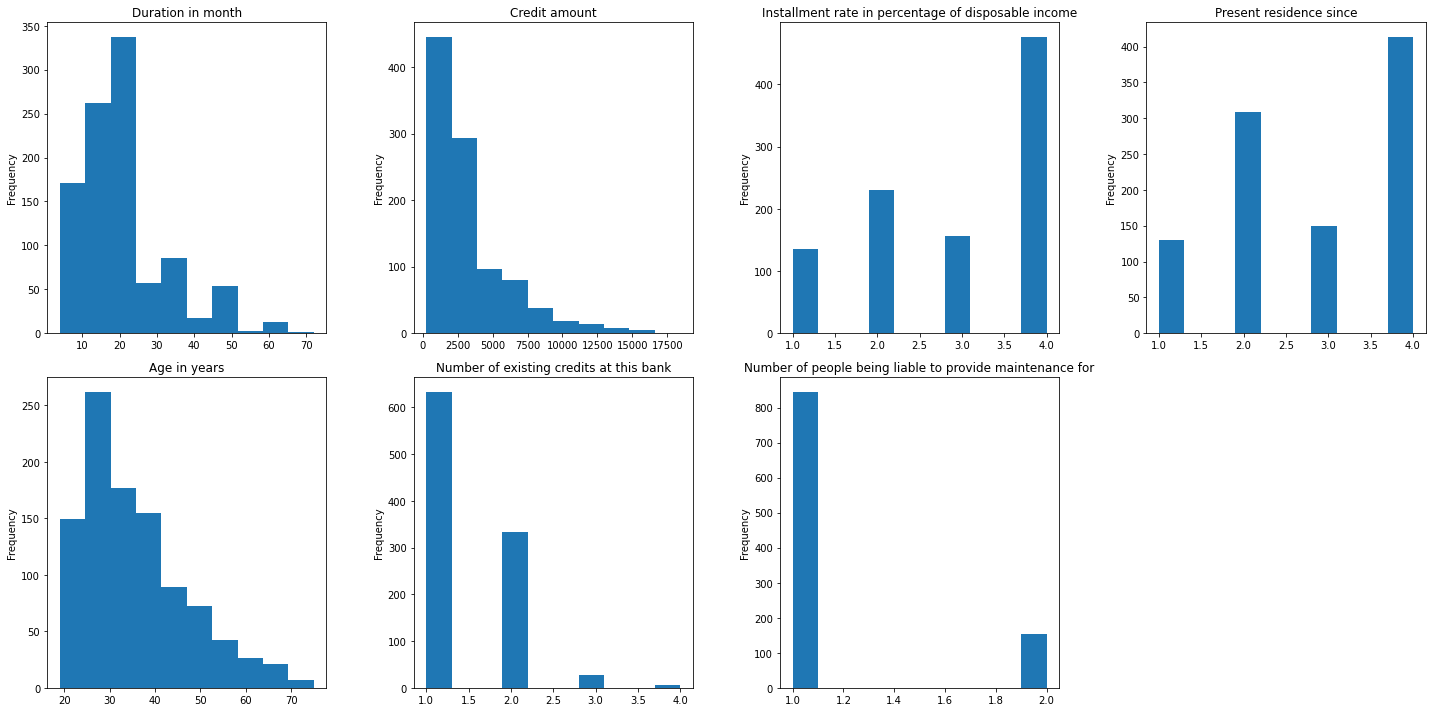

In [ ]:
# bar plot
numerical_features = df.select_dtypes(exclude=['object']).columns
n_col = 4
n_row =  math.ceil( len(numerical_features)/n_col )
fig, ax = pyplot.subplots(n_row, n_col, figsize=(20,10))
for i, numerical_feature in enumerate(df[numerical_features]):
    row = int(i/n_col)
    col = i%n_col
    df[numerical_feature].plot(kind='hist', ax=ax[row,col]).set_title(numerical_feature)
ax[1,3].set_axis_off()
fig.tight_layout()
fig.show()

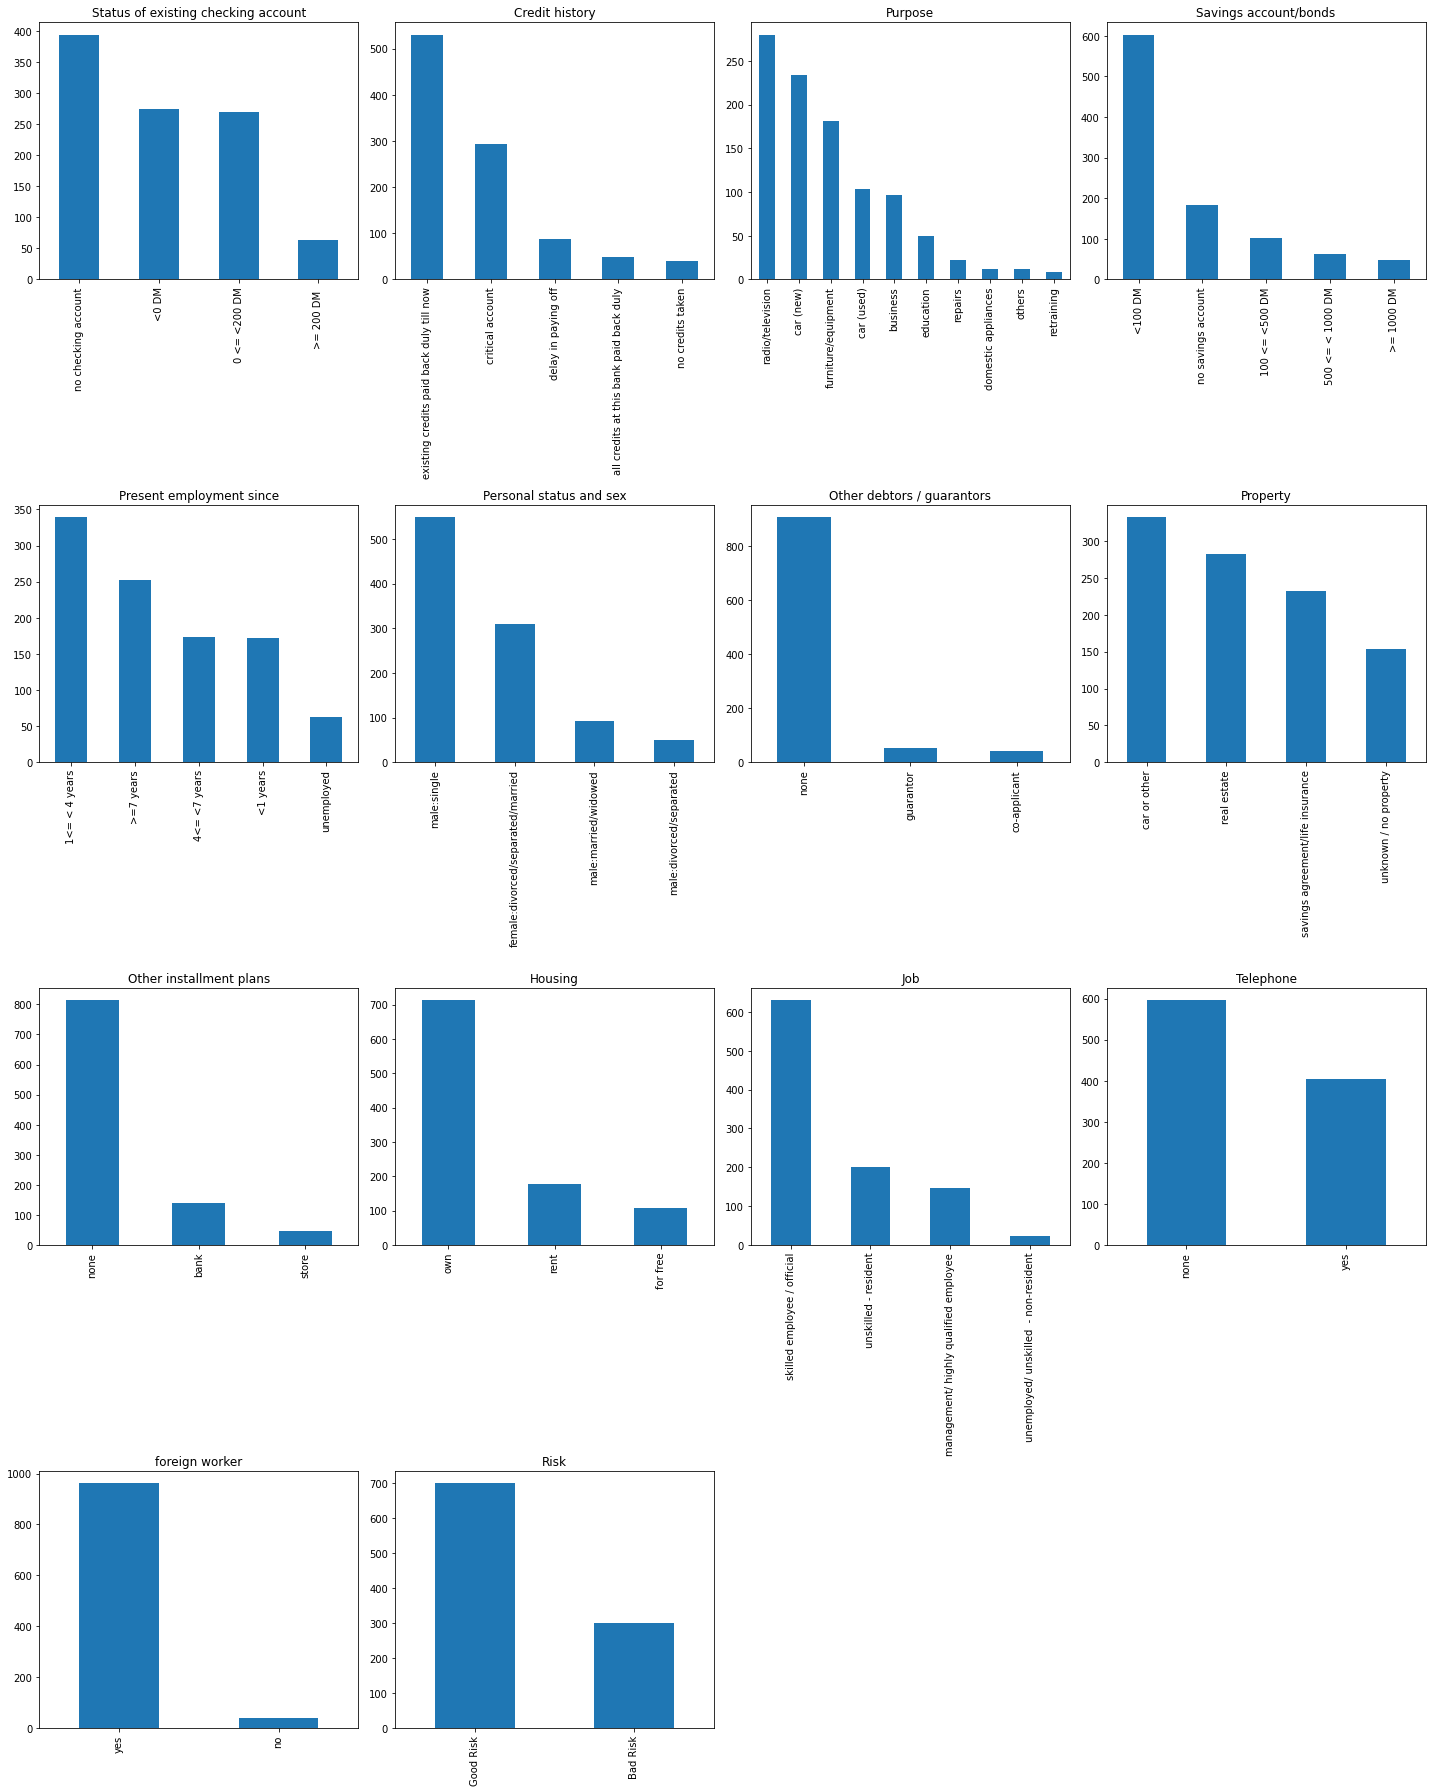

In [ ]:
# bar plot
categorical_features = df.select_dtypes(['object']).columns
n_col = 4
n_row =  math.ceil( len(categorical_features)/n_col )
fig, ax = pyplot.subplots(n_row, n_col, figsize=(20,25))
for i, categorical_feature in enumerate(df[categorical_features]):
    row = int(i/n_col)
    col = i%n_col
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[row,col]).set_title(categorical_feature)
ax[3,2].set_axis_off()
ax[3,3].set_axis_off()
fig.tight_layout()
fig.show()

### Analyse bivariée

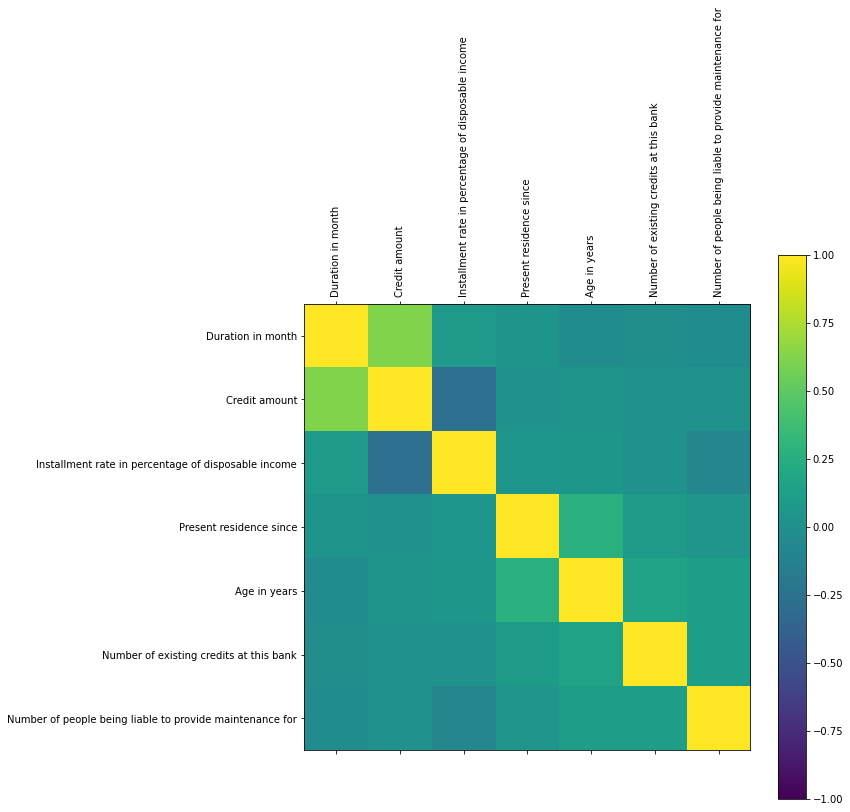

In [ ]:
# correlation matrix
name = list(df.select_dtypes(exclude=['object']).columns)
fig = pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ax.set_xticklabels(['']+name)
ax.set_yticklabels(['']+name)
pyplot.xticks(rotation=90)
pyplot.show()

On remarque qu'il y a une corrélation positive entre le montant du crédit et la durée du crédit. Cela est normal car plus le montant du crédit est élevé, plus cela s'étale sur dans le temps.

On remarque également qu'il y a une corrélation négative entre le montant du crédit et le taux de versement en pourcentage du revenu disponible.

In [ ]:
def visualize_distribution(attr):
    good_risk_df = df[df["Risk"]=="Good Risk"]
    bad_risk_df = df[df["Risk"]=="Bad Risk"]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    attr_good_risk_df = good_risk_df[[attr, 'Risk']].groupby(attr).count()
    attr_bad_risk_df = bad_risk_df[[attr, 'Risk']].groupby(attr).count()
    ax[0].barh( attr_good_risk_df['Risk'].index.tolist(), attr_good_risk_df['Risk'].tolist(), align='center', color="#5975A4")
    ax[1].barh( attr_bad_risk_df['Risk'].index.tolist(), attr_bad_risk_df['Risk'].tolist(), align='center', color="#B55D60")
    ax[0].set_title('Good Risk')
    ax[1].set_title('Bad Risk')
    ax[0].invert_xaxis()
    ax[1].yaxis.tick_right()
    ax[0].grid(True)
    ax[1].grid(True)

    lim_0 = max(ax[0].get_xlim())
    lim_1 = max(ax[1].get_xlim())
    if(lim_0 > lim_1):
      ax[1].set_xlim(0,lim_0)
    else:
      ax[0].set_xlim(lim_1, 0)      

    for i, v in enumerate(attr_good_risk_df['Risk'].tolist()):
        ax[0].text(v+25, i + .05, str(v), color='black')
    for i, v in enumerate(attr_bad_risk_df['Risk'].tolist()):
        ax[1].text(v+1, i + .05, str(v), color='black')
    
    plt.suptitle(attr)
    plt.tight_layout()
    plt.show()

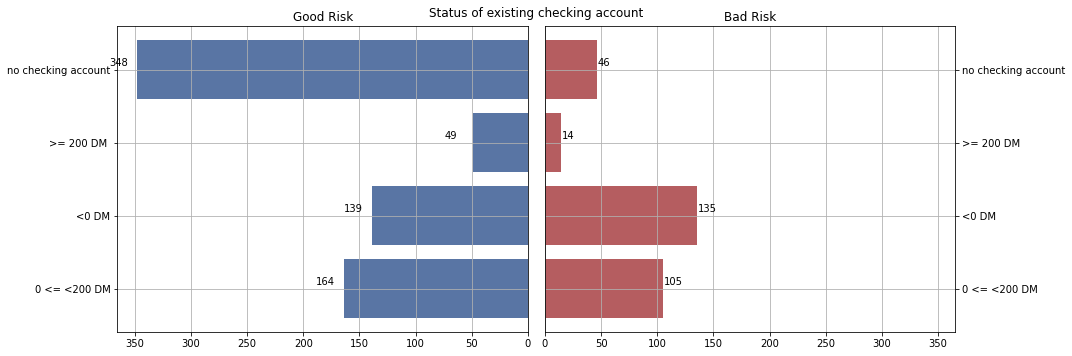

In [ ]:
visualize_distribution("Status of existing checking account")

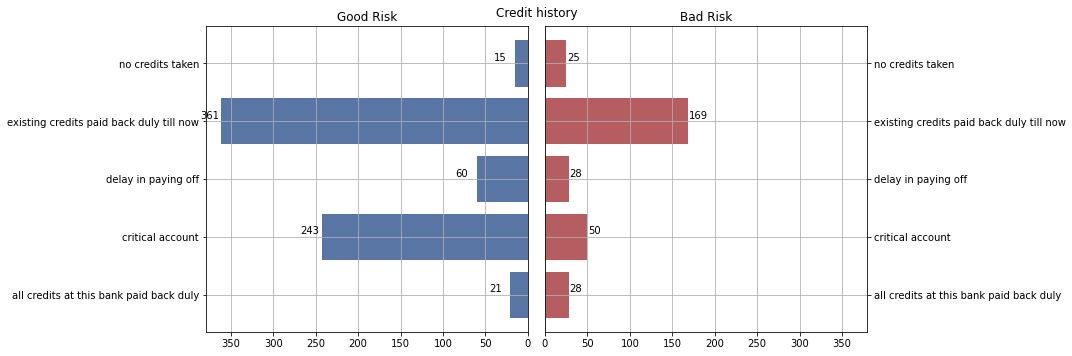

In [ ]:
visualize_distribution("Credit history")

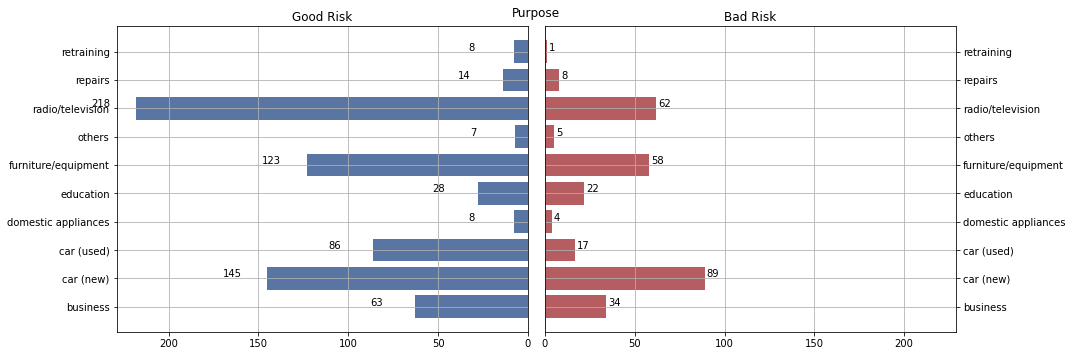

In [ ]:
visualize_distribution("Purpose")

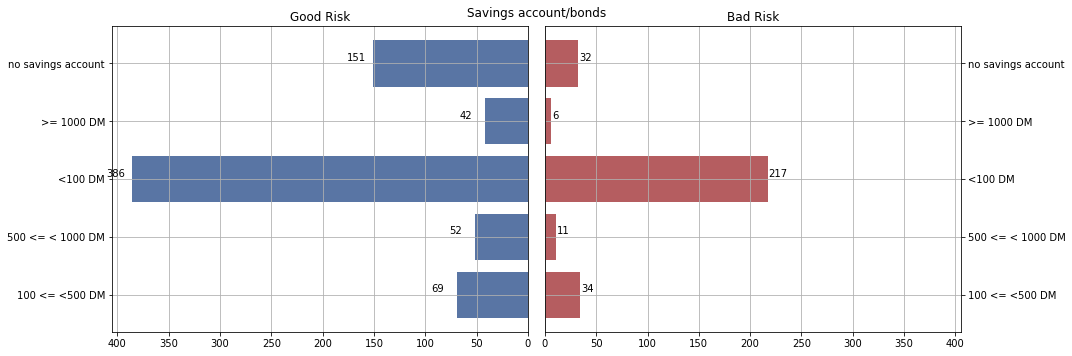

In [ ]:
visualize_distribution("Savings account/bonds")

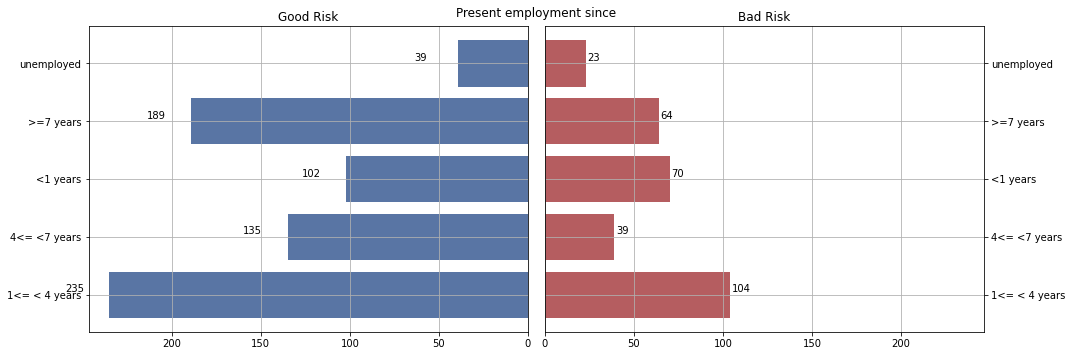

In [ ]:
visualize_distribution("Present employment since")

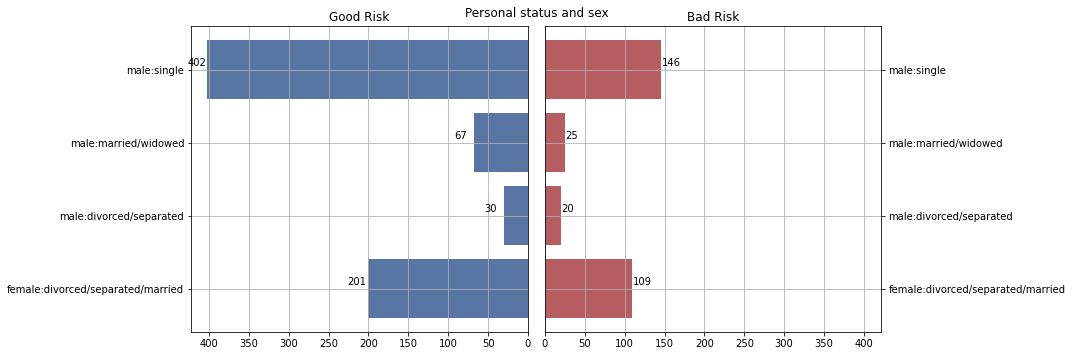

In [ ]:
visualize_distribution("Personal status and sex")

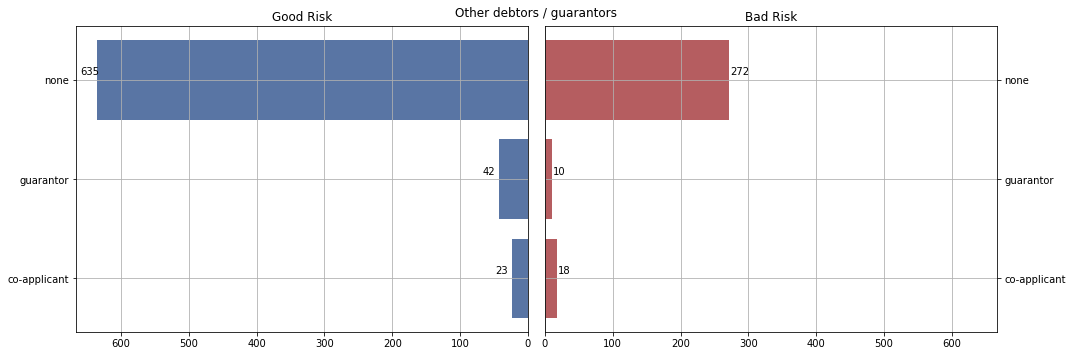

In [ ]:
visualize_distribution("Other debtors / guarantors")

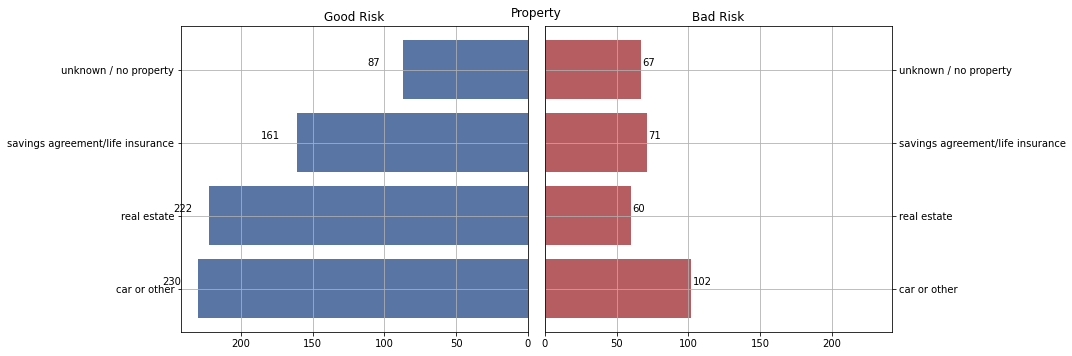

In [ ]:
visualize_distribution("Property")

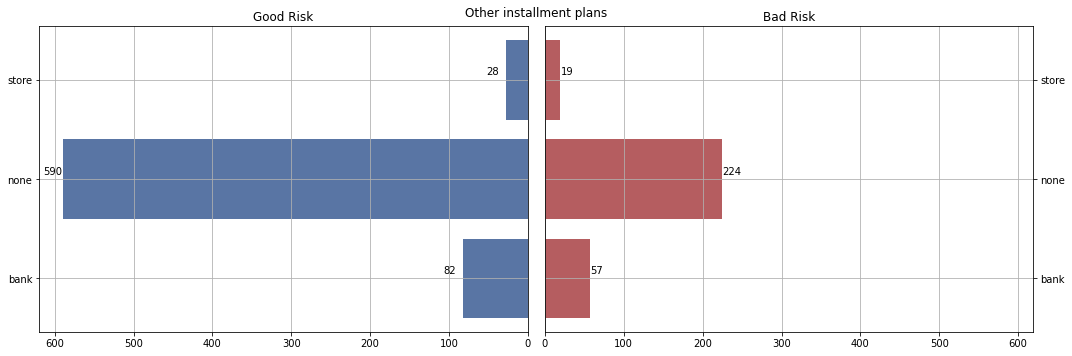

In [ ]:
visualize_distribution("Other installment plans")

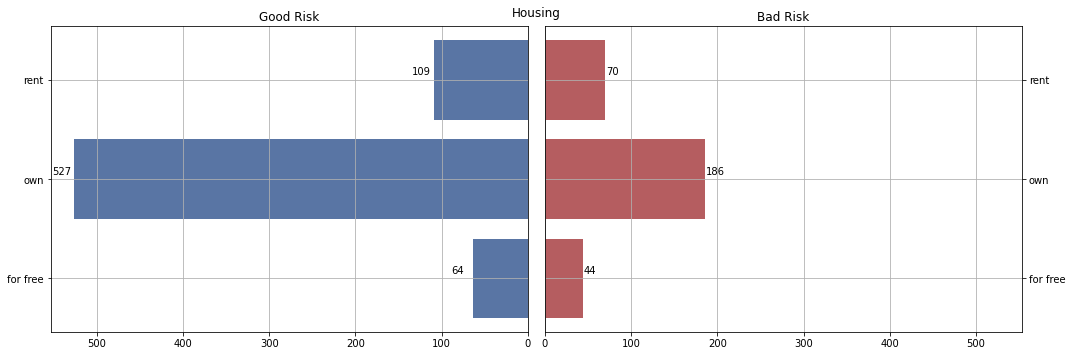

In [ ]:
visualize_distribution("Housing")

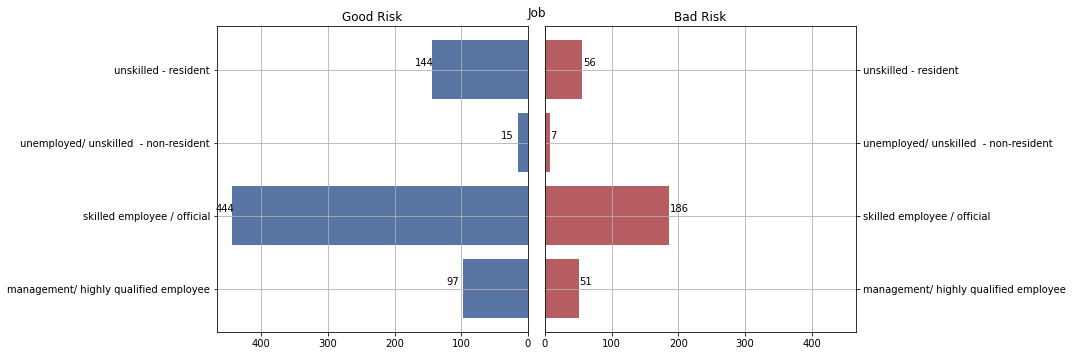

In [ ]:
visualize_distribution("Job")

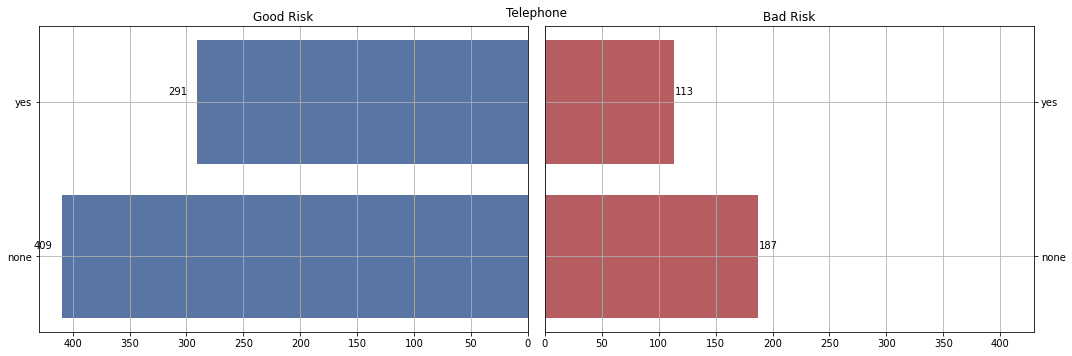

In [ ]:
visualize_distribution("Telephone")

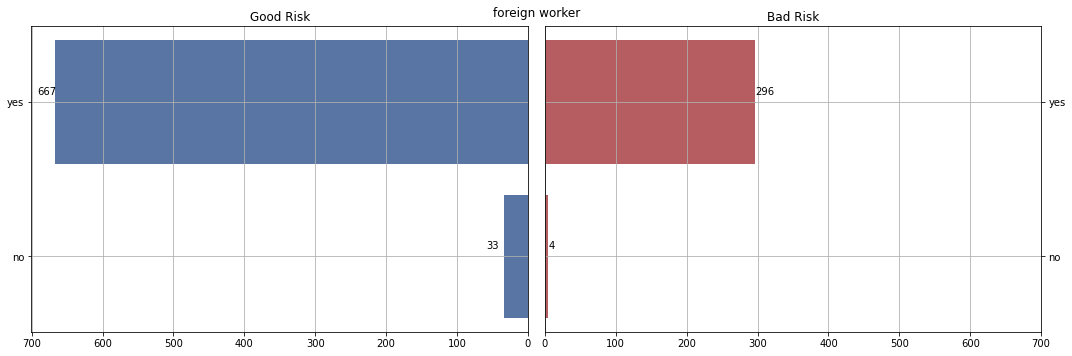

In [ ]:
visualize_distribution("foreign worker")

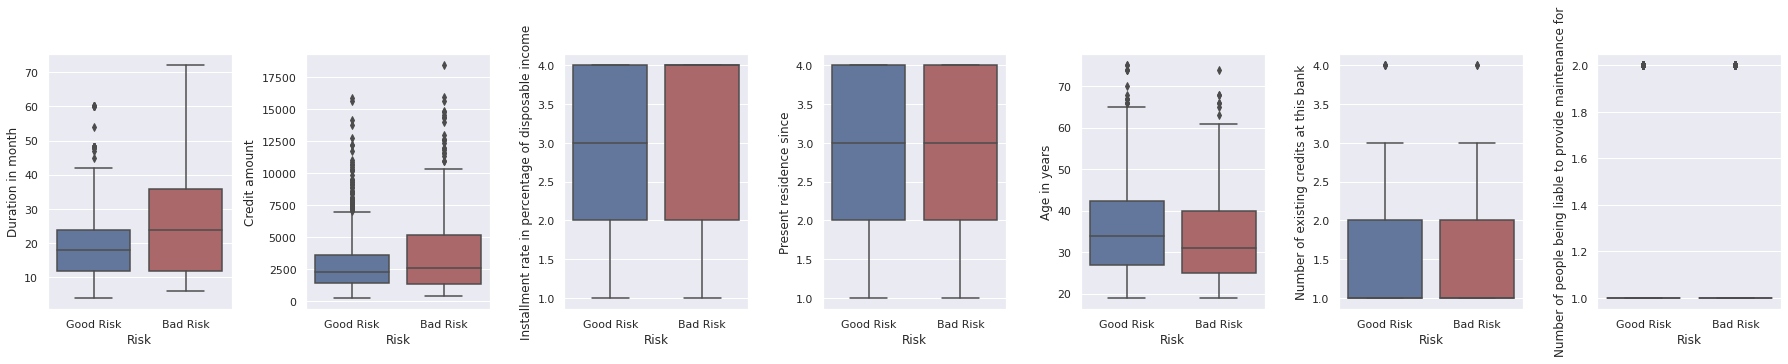

In [ ]:
sns.set()
f, axes = plt.subplots(1, 7,figsize=(25,5))
sns.boxplot(y=df["Duration in month"],x=df["Risk"], orient='v' , ax=axes[0],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Credit amount"],x=df["Risk"],orient='v' , ax=axes[1],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Installment rate in percentage of disposable income"],x=df["Risk"], orient='v' , ax=axes[2],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Present residence since"],x=df["Risk"], orient='v' , ax=axes[3],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Age in years"],x=df["Risk"], orient='v' , ax=axes[4],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Number of existing credits at this bank"],x=df["Risk"], orient='v' , ax=axes[5],palette=["#5975A4","#B55D60"]) #box plot
sns.boxplot(y=df["Number of people being liable to provide maintenance for"],x=df["Risk"], orient='v' , ax=axes[6],palette=["#5975A4","#B55D60"]) #box plot
plt.tight_layout()
plt.show()

## Préparation des données

In [ ]:
# feature selection
attributs=["Status of existing checking account","Credit history","Purpose",\
"Savings account/bonds","Present employment since",\
"Personal status and sex","Property","Other installment plans","Housing","foreign worker",\
"Credit amount","Age in years","Duration in month"]
target_variable=["Risk"]
df=df[attributs+target_variable]

Parmi toutes le variables, on ne retient que celles qui permettraient le plus d"indentifier le risque client. 

In [ ]:
# converting target variable into numeric
risk={"Good Risk":1, "Bad Risk":0}
df["Risk"]=df["Risk"].map(risk)

# converting categorical variables into dummies
col_cat_names= df.select_dtypes(['object']).columns
for attr in col_cat_names:
    df = df.merge(pd.get_dummies(df[attr], prefix=attr), left_index=True, right_index=True)
    df.drop(attr,axis=1,inplace=True)

On transforme les variables catégorielles en numériques afin que les modèles linéaires puissent également les utiliser lors de l'entrainement.

In [ ]:
# view of the dataset for modelling
df.head()

,Credit amount,Age in years,Duration in month,Risk,Status of existing checking account_0 <= <200 DM,Status of existing checking account_<0 DM,Status of existing checking account_>= 200 DM,Status of existing checking account_no checking account,Credit history_all credits at this bank paid back duly,Credit history_critical account,Credit history_delay in paying off,Credit history_existing credits paid back duly till now,Credit history_no credits taken,Purpose_business,Purpose_car (new),Purpose_car (used),Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_others,Purpose_radio/television,Purpose_repairs,Purpose_retraining,Savings account/bonds_100 <= <500 DM,Savings account/bonds_500 <= < 1000 DM,Savings account/bonds_<100 DM,Savings account/bonds_>= 1000 DM,Savings account/bonds_no savings account,Present employment since_1<= < 4 years,Present employment since_4<= <7 years,Present employment since_<1 years,Present employment since_>=7 years,Present employment since_unemployed,Personal status and sex_female:divorced/separated/married,Personal status and sex_male:divorced/separated,Personal status and sex_male:married/widowed,Personal status and sex_male:single,Property_car or other,Property_real estate,Property_savings agreement/life insurance,Property_unknown / no property,Other installment plans_bank,Other installment plans_none,Other installment plans_store,Housing_for free,Housing_own,Housing_rent,foreign worker_no,foreign worker_yes
0,1169,67,6,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1
1,5951,22,48,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
2,2096,49,12,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1
3,7882,45,42,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
4,4870,53,24,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1


In [ ]:
df.shape

(1000, 49)

Le jeu de données contient maintenant 49 variables. 

In [ ]:
# variables explicatives
X = df.drop('Risk', 1).values 

# variables à expliquer, prédire
y = df["Risk"].values 

Les classes n'étant pas équilibrés, lors de l'entrainement du modèle, la classe majoritaire va être favorisée. Pour éviter cela, on utilise une méthode combinant le over et under sampling.

In [ ]:
# Combination of over- and under-sampling
sm = SMOTETomek(random_state=0)
X_resampled , y_resampled = sm.fit_resample(X,y) 

On divise le jeu de données en 2 : 'train' va servir à l'entrainement du modèle, qui va ensuite être tester sur 'test'.

In [ ]:
# Split-out validation df
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X_resampled, y_resampled, test_size=validation_size, random_state=seed)
print("Dimension des données d'entrainement : ", X_train.shape)
print("Dimension des données de validation : ", X_validation.shape)

Dimension des données d'entrainement :  (966, 48)
Dimension des données de validation :  (242, 48)


## Evaluation des algorithmes

Pour chacun des modèles, on va réaliser une cross-validation. 

In [ ]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

In [ ]:
# Spot Check Algorithms
models = []
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('SVM', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))

results = []
names = []
scores = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results_acc = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	cv_results_precis = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='precision')
	cv_results_recall = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
	cv_results_fscore = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
	
	results.append(cv_results_acc)
	names.append(name)
	scores.append([name, round(cv_results_acc.mean(),2), round(cv_results_precis.mean(),2), round(cv_results_recall.mean(),2), round(cv_results_fscore.mean(),2)])

df_score = pd.DataFrame(scores, columns=['Modele', 'accuracy', 'precision', 'recall', 'f_score'])
print(tabulate(df_score, headers='keys'))

    Modele      accuracy    precision    recall    f_score
--  --------  ----------  -----------  --------  ---------
 0  NB              0.8          0.8       0.79       0.8
 1  KNN             0.67         0.69      0.58       0.63
 2  LDA             0.81         0.78      0.86       0.82
 3  QDA             0.8          0.71      1          0.83
 4  SVM             0.56         0.53      0.86       0.66
 5  LR              0.81         0.82      0.8        0.81
 6  CART            0.77         0.77      0.75       0.77


Les résultats sont assez bons pour ces méthodes, excepté pour la SVM.

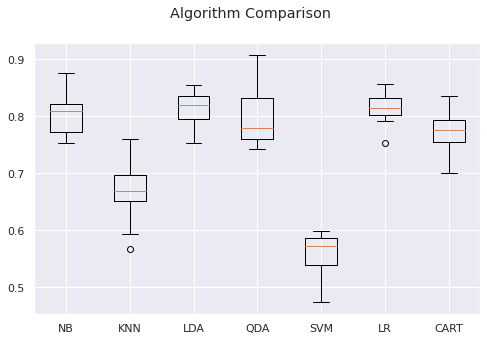

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(8,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Pour chacun des modèle, on remarque des résultats similaires durant la cross-validation. 

On va maintenant entrainer les modèles sur des données normalisées.

In [ ]:
# Standardize the df
pipelines = []
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledQDA', Pipeline([('Scaler', StandardScaler()),('QDA', QuadraticDiscriminantAnalysis())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))

results = []
names = []
scores = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results_acc = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	cv_results_precis = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='precision')
	cv_results_recall = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
	cv_results_fscore = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
	results.append(cv_results_acc)
	names.append(name)
	scores.append([name, round(cv_results_acc.mean(),2), round(cv_results_precis.mean(),2), round(cv_results_recall.mean(),2), round(cv_results_fscore.mean(),2)])
 
df_score = pd.DataFrame(scores, columns=['Modele', 'accuracy', 'precision', 'recall', 'f_score'])
print(tabulate(df_score, headers='keys'))

    Modele        accuracy    precision    recall    f_score
--  ----------  ----------  -----------  --------  ---------
 0  ScaledNB          0.68         0.84      0.43       0.57
 1  ScaledKNN         0.79         0.78      0.79       0.78
 2  ScaledLDA         0.81         0.78      0.86       0.82
 3  ScaledQDA         0.8          0.71      0.99       0.83
 4  ScaledSVM         0.83         0.78      0.92       0.84
 5  ScaledLR          0.81         0.78      0.86       0.82
 6  ScaledCART        0.78         0.78      0.75       0.76


En normalisant les données, on obtient de meilleurs résultats, en particulier pour la SVM.

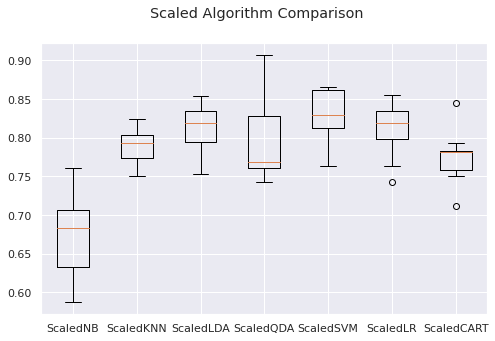

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(8,5))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Les résultats de Naive Bayes et de QDA varient un peu durant l'entrainement avec cross-validation.

**Méthodes ensemblistes**

In [ ]:
# ensembles
ensembles = []
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('XGB', XGBClassifier()))
ensembles.append(('AB', AdaBoostClassifier()))

results = []
names = []
scores = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results_acc = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	cv_results_precis = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='precision')
	cv_results_recall = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
	cv_results_fscore = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
	results.append(cv_results_acc)
	names.append(name)
	scores.append([name, round(cv_results_acc.mean(),2), round(cv_results_precis.mean(),2), round(cv_results_recall.mean(),2), round(cv_results_fscore.mean(),2)])
 
df_score = pd.DataFrame(scores, columns=['Modele', 'accuracy', 'precision', 'recall', 'f_score'])
print(tabulate(df_score, headers='keys'))

    Modele      accuracy    precision    recall    f_score
--  --------  ----------  -----------  --------  ---------
 0  RF              0.83         0.83      0.84       0.83
 1  ET              0.81         0.8       0.83       0.81
 2  GBM             0.83         0.82      0.83       0.82
 3  XGB             0.83         0.82      0.83       0.82
 4  AB              0.82         0.82      0.81       0.81


Les résultats sont similaires pour tous les modèles, avec Random forest légèrement meilleur.

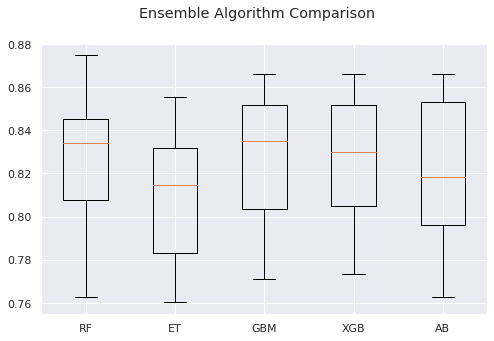

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(8,5))
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

En comparant les modèles avec toutes les métriques, c'est le random forest qui affichent les meilleurs scores.

Globalement, les méthodes ensemblistes sont plus robustes et performent mieux.

Accuracy :  0.83
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       117
           1       0.82      0.86      0.84       125

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



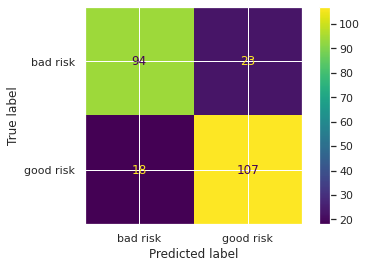

In [ ]:
# Finalize Model

# prepare the model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, Y_train)
# estimate accuracy on validation df
predictions = model.predict(X_validation)
ConfusionMatrixDisplay.from_predictions(Y_validation, predictions, display_labels=['bad risk','good risk']) 
print('Accuracy : ', round(accuracy_score(Y_validation, predictions),2))
print(classification_report(Y_validation, predictions)) 

La méthode Random Forest est retenue pour la prédiction du risque avec le client. Elle donne des scores satisfaisants pour toutes les métriques : accuracy, précision, recall et f1-score (>80%)

# Données relationnelles 

In [ ]:
data_citeseer = mat_to_df("/content/drive/MyDrive/Cours/M2/Apprentissage Supervisé/Projet/Donnees_relationnelles/citeseer.mat")
data_cora = mat_to_df("/content/drive/MyDrive/Cours/M2/Apprentissage Supervisé/Projet/Donnees_relationnelles/cora.mat")
data_pubmed = mat_to_df("/content/drive/MyDrive/Cours/M2/Apprentissage Supervisé/Projet/Donnees_relationnelles/pubmed.mat")

## Etude exploratoire 

### Dataset Citiseer

In [ ]:
print(f"Dataset Citiseer - matrice X : \n\n{data_citeseer['X'].head()} \n\n")
print(f"Dataset Citiseer - matrice d'adjacence : \n\n{data_citeseer['matrice_adjacence'].head()}")

Dataset Citiseer - matrice X : 

   0     1     2     3     4     5     ...  3697  3698  3699  3700  3701  3702
0     0     0     0     0     0     0  ...     0     0     0     0     0     0
1     0     0     0     0     0     0  ...     0     0     0     0     0     0
2     0     0     0     0     0     0  ...     0     0     0     0     0     0
3     0     0     0     0     0     0  ...     0     0     0     0     0     0
4     0     0     0     0     0     0  ...     0     0     0     0     0     0

[5 rows x 3703 columns] 


Dataset Citiseer - matrice d'adjacence : 

   0     1     2     3     4     5     ...  3321  3322  3323  3324  3325  3326
0     0     0     0     0     0     0  ...     0     0     0     0     0     0
1     0     0     0     0     0     0  ...     0     0     0     0     0     0
2     0     0     0     0     0     0  ...     0     0     0     0     0     0
3     0     0     0     0     0     0  ...     0     0     0     0     0     0
4     0     0     0     0  

In [ ]:
print(f"Il y a {int(np.sum(np.sum(data_citeseer['matrice_adjacence'])/2))} liens entre les {data_citeseer['X'].shape[1]} features de la dataset Citiseer")

Il y a 4614 liens entre les 3703 features de la dataset Citiseer


Dataset Citiseer - labels : {1, 2, 3, 4, 5, 6} 



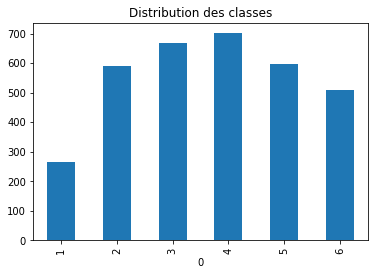

In [ ]:
print(f"Dataset Citiseer - labels : {set(data_citeseer['labels'].loc[:,0])} \n")
data_citeseer['labels'].groupby(0).size().plot(kind = 'bar', title='Distribution des classes');

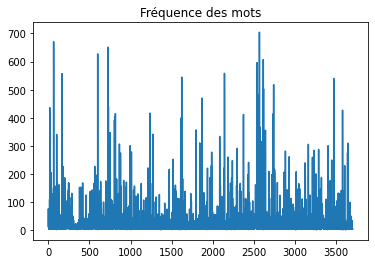

In [ ]:
np.sum(data_citeseer['X']).plot(title='Fréquence des mots');

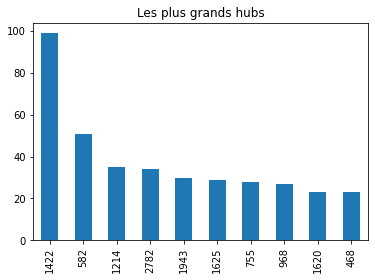

In [ ]:
# On somme la matrice pour obtenir le nombre de liens
np.sum(data_citeseer['matrice_adjacence']).sort_values(ascending=False).head(10).plot(kind='bar', title="Les plus grands hubs");

### Dataset Cora

In [ ]:
print(f"Dataset Cora - matrice X : \n\n{data_cora['X'].head()} \n\n")
print(f"Dataset Cora - matrice d'adjacence : \n\n{data_cora['matrice_adjacence'].head()}")

Dataset Cora - matrice X : 

   0     1     2     3     4     5     ...  1427  1428  1429  1430  1431  1432
0     0     0     0     0     0     0  ...     0     0     0     0     0     0
1     0     0     0     0     0     0  ...     0     0     0     0     0     0
2     0     0     0     0     0     0  ...     0     0     0     0     0     0
3     0     0     0     0     0     0  ...     0     0     0     0     0     0
4     0     0     0     1     0     0  ...     0     0     0     0     0     0

[5 rows x 1433 columns] 


Dataset Cora - matrice d'adjacence : 

   0     1     2     3     4     5     ...  2702  2703  2704  2705  2706  2707
0     0     0     0     0     0     0  ...     0     0     0     0     0     0
1     0     0     1     0     0     0  ...     0     0     0     0     0     0
2     0     1     0     0     0     0  ...     0     0     0     0     0     0
3     0     0     0     0     0     0  ...     0     0     0     0     0     0
4     0     0     0     0     0    

In [ ]:
print(f"Il y a {int(np.sum(np.sum(data_cora['matrice_adjacence'])/2))} liens entre les {data_cora['X'].shape[1]} features de la dataset Cora\n")

Il y a 5278 liens entre les 1433 features de la dataset Cora



Dataset Cora - labels : {1, 2, 3, 4, 5, 6, 7} 



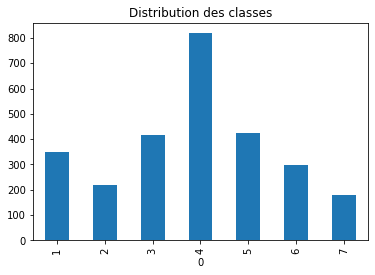

In [ ]:
print(f"Dataset Cora - labels : {set(data_cora['labels'].loc[:,0])} \n")
data_cora['labels'].groupby(0).size().plot(kind = 'bar', title='Distribution des classes');

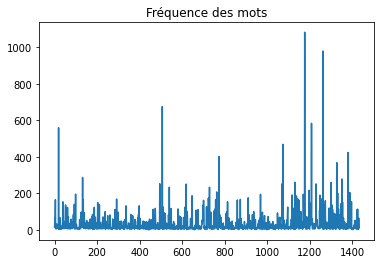

In [ ]:
np.sum(data_cora['X']).plot(title='Fréquence des mots');

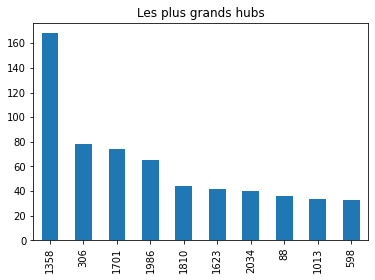

In [ ]:
# On somme la matrice pour obtenir le nombre de liens
np.sum(data_cora['matrice_adjacence']).sort_values(ascending=False).head(10).plot(kind='bar', title="Les plus grands hubs");

### Dataset Pubmed

In [ ]:
print(f"Dataset Pubmed - matrice X : \n\n{data_pubmed['X'].head()} \n\n")
print(f"Dataset Pubmed - matrice d'adjacence : \n\n{data_pubmed['matrice_adjacence'].head()}")

Dataset Pubmed - matrice X : 

        0    1    2    3         4    5    ...  494  495  496  497  498  499
0  0.000000  0.0  0.0  0.0  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
1  0.000000  0.0  0.0  0.0  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
2  0.104636  0.0  0.0  0.0  0.035178  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
3  0.000000  0.0  0.0  0.0  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
4  0.000000  0.0  0.0  0.0  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 500 columns] 


Dataset Pubmed - matrice d'adjacence : 

   0      1      2      3      4      ...  19712  19713  19714  19715  19716
0    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
1    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
2    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
3    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
4    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.

In [ ]:
print(f"Il y a {int(np.sum(np.sum(data_pubmed['matrice_adjacence'])/2))} liens entre les {data_pubmed['X'].shape[1]} features de la dataset Pubmed\n")

Il y a 44325 liens entre les 500 features de la dataset Pubmed



Dataset Pubmed - labels : {1, 2, 3}


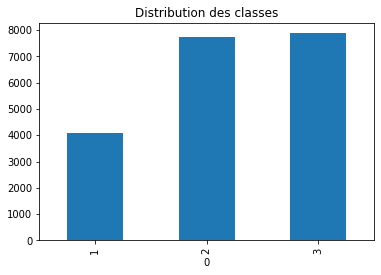

In [ ]:
print(f"Dataset Pubmed - labels : {set(data_pubmed['labels'].loc[:,0])}")
data_pubmed['labels'].groupby(0).size().plot(kind = 'bar', title='Distribution des classes');

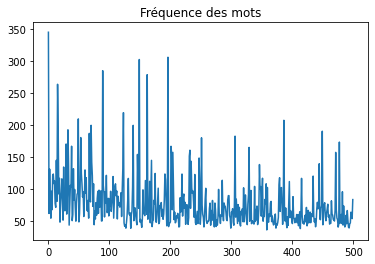

In [ ]:
np.sum(data_pubmed['X']).plot(title='Fréquence des mots');

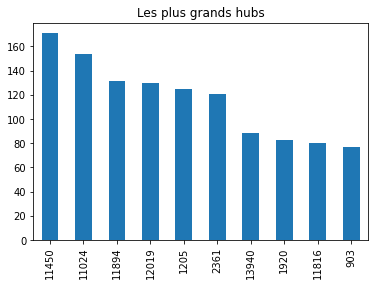

In [ ]:
# On somme la matrice pour obtenir le nombre de liens
np.sum(data_pubmed['matrice_adjacence']).sort_values(ascending=False).head(10).plot(kind='bar', title="Les plus grands hubs");

## Classification

### Dataset Citiseer

#### Uniquement avec la matrice X

On divise la matrice X en 60% de données d'entrainement et 40% de données de test.

In [ ]:
train_citiseer_X, test_citiseer_X, train_citiseer_X_lab, test_citiseer_X_lab = train_test_split(data_citeseer['X'], data_citeseer['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_citiseer_X.shape)
print("Dimension des données de test : ", test_citiseer_X.shape)

Dimension des données d'entrainement :  (1996, 3703)
Dimension des données de test :  (1331, 3703)


On veut apprendre un modèle à classer des vecteurs nos individus. On sait que plus le nombre de features (dimension) augmente, plus les vecteurs se ressemble c'est-à-dire sont proches les uns des autres. Ceci est d'autant plus vrai si les vecteurs sont binaires (composés de 0 et de 1). Appliquer des modèles basés sur la distance entre les individus de la dataset brute est donc inefficace comme on peut le voir ci-dessous avec l'algorithme KNN.


In [ ]:
knn = KNeighborsClassifier(n_neighbors=20).fit(train_citiseer_X, train_citiseer_X_lab)
knn_scores = print_scores(knn, test_citiseer_X, test_citiseer_X_lab)

Accuracy  : 0.083
F1 score  : 0.025
NMI score : 0.002


On se propose de travailler avec des arbres de décisions ou des randoms forest pour tirer profit du caractère binaire de nos vecteurs

In [ ]:
dtree = DecisionTreeClassifier(random_state=42).fit(train_citiseer_X, train_citiseer_X_lab)
dtree_scores = print_scores(dtree, test_citiseer_X, test_citiseer_X_lab)

Accuracy  : 0.597
F1 score  : 0.568
NMI score : 0.271


In [ ]:
forest = RandomForestClassifier(random_state=42, n_estimators=500).fit(train_citiseer_X, train_citiseer_X_lab)
forest_scores = print_scores(forest, test_citiseer_X, test_citiseer_X_lab)

Accuracy  : 0.721
F1 score  : 0.674
NMI score : 0.432


On peut expliquer le premier résultat (59.7%) par l'instabilité de l'arbre de décision car l'apparition d'un mot dans le vecteur varie fortement même entre les données d'une même classe. La forêt aléatoire quantt à elle remédie bien à ce problème en présentant 72.1% de bon classement.

On se propose enfin d'appliquer une régression logistique classique, un XBGBoost et un AdaBoost

In [ ]:
print("----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_citiseer_X, train_citiseer_X_lab)
lr_scores = print_scores(lr, test_citiseer_X, test_citiseer_X_lab)

print("\n------------ XGB Classifier ------------\n")
xgb_clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 50).fit(train_citiseer_X, train_citiseer_X_lab)
xgb_clf_scores = print_scores(xgb_clf, test_citiseer_X, test_citiseer_X_lab)

print("\n--------- AdaBoost Classifier ----------\n")
ada = AdaBoostClassifier(learning_rate = 0.1, random_state=42, n_estimators=300).fit(train_citiseer_X, train_citiseer_X_lab)
ada_scores = print_scores(ada, test_citiseer_X, test_citiseer_X_lab)

----- Logistic Regression Classifier -----

Accuracy  : 0.711
F1 score  : 0.683
NMI score : 0.417

------------ XGB Classifier ------------

Accuracy  : 0.69
F1 score  : 0.651
NMI score : 0.396

--------- AdaBoost Classifier ----------

Accuracy  : 0.637
F1 score  : 0.59
NMI score : 0.345


Pour tous les modèles ci-dessous, on pourrait faire un tuning sur les modèles les plus prometteurs (ici les forêts aléatoires et la régression logistique) pour selectionner les meilleurs paramètres. Toutefois, lançons nous dans l'utilisation de la matrice d'adjacence

#### Avec les informations W et X

      0     1     2     3     4     5     ...  3697  3698  3699  3700  3701  3702
0      0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
1      0.0   0.2   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2      0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3      0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4      0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
3322   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3323   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3324   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3325   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3326   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[3327 rows x 37

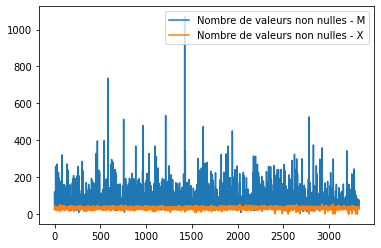

In [ ]:
# Construction de la matrice des degrés D
D = np.diag(np.sum(data_citeseer['matrice_adjacence'], axis=1))
D_inv = np.diag(  1/np.diag(D)  )

# Construction de la matrice M
M = np.matmul(  np.matmul(D_inv, data_citeseer['matrice_adjacence'])  ,  data_citeseer['X']  )

print(M, '\n')

plt.plot(M.index, np.count_nonzero(M, axis=1), label="Nombre de valeurs non nulles - M")
plt.plot(M.index, np.count_nonzero(data_citeseer['X'], axis=1), label="Nombre de valeurs non nulles - X")
plt.legend();

Au vu des calculs, chaque individu de la matrice M correspond à une transformation de l'individu du même index de la matrice X. On voit de plus que cette transformation réduit drastiquement la sparsité de la matrice de départ.

In [ ]:
train_X, test_X, train_X_lab, test_X_lab = train_test_split(M, data_citeseer['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_X.shape)
print("Dimension des données de test : ", test_X.shape)

Dimension des données d'entrainement :  (1996, 3703)
Dimension des données de test :  (1331, 3703)


On peut se convaincre de ce fait en effectuant un KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10).fit(train_X, train_X_lab)
knn_scores = print_scores(knn, test_X, test_X_lab)

Accuracy  : 0.54
F1 score  : 0.478
NMI score : 0.295


En effet, les données étant moins sparses et donc plus distinctibles en grandes dimensions, le KNN donne des meilleurs résultats que sur la matrice X.

In [ ]:
print("------- Random Forest Classifier -------\n")
forest = RandomForestClassifier(random_state=42, n_estimators=200).fit(train_X, train_X_lab)
forest_scores = print_scores(forest, test_X, test_X_lab)

print("\n----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_X, train_X_lab)
lr_scores = print_scores(lr, test_X, test_X_lab)

------- Random Forest Classifier -------

Accuracy  : 0.696
F1 score  : 0.635
NMI score : 0.4

----- Logistic Regression Classifier -----

Accuracy  : 0.687
F1 score  : 0.641
NMI score : 0.391


Mais on voit que sur le reste des méthodes, les résultats sont légèrement moins bons lorsqu'on combine les deux matrices.

### Dataset Cora

#### Uniquement avec la matrice X

On divise la matrice X en 60% de données d'entrainement et 40% de données de test.

In [ ]:
train_X, test_X, train_X_lab, test_X_lab = train_test_split(data_cora['X'], data_cora['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_X.shape)
print("Dimension des données de test : ", test_X.shape)

Dimension des données d'entrainement :  (1624, 1433)
Dimension des données de test :  (1084, 1433)


Les données de la dataset Cora sont moins sparses que celles de la dataset Citiseer. Les résultats dévraient donc être globalement meilleurs que pour cette dernière. <br>
Ceci étant dit, on a pu remarquer dans la phase exploratoire que les classes sont moins homogènes pour cette dataset que pour les deux autres. En effet, la classe 4 est largement plus representée que le reste des classes.

In [ ]:
dtree = DecisionTreeClassifier(random_state=42).fit(train_X, train_X_lab)
dtree_scores = print_scores(dtree, test_X, test_X_lab)

Accuracy  : 0.622
F1 score  : 0.599
NMI score : 0.322


In [ ]:
forest = RandomForestClassifier(random_state=42, n_estimators=200).fit(train_X, train_X_lab)
forest_scores = print_scores(forest, test_X, test_X_lab)

Accuracy  : 0.737
F1 score  : 0.718
NMI score : 0.47


In [ ]:
print("----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_X, train_X_lab)
lr_scores = print_scores(lr, test_X, test_X_lab)

print("\n------------ XGB Classifier ------------\n")
xgb_clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 50).fit(train_X, train_X_lab)
xgb_clf_scores = print_scores(xgb_clf, test_X, test_X_lab)

print("\n--------- AdaBoost Classifier ----------\n")
ada = AdaBoostClassifier(learning_rate = 0.1, random_state=42, n_estimators=300).fit(train_X, train_X_lab)
ada_scores = print_scores(ada, test_X, test_X_lab)

----- Logistic Regression Classifier -----

Accuracy  : 0.745
F1 score  : 0.72
NMI score : 0.477

------------ XGB Classifier ------------

Accuracy  : 0.733
F1 score  : 0.715
NMI score : 0.466

--------- AdaBoost Classifier ----------

Accuracy  : 0.522
F1 score  : 0.448
NMI score : 0.255


#### Avec les informations W et X

      0     1     2     3         4     ...  1428  1429  1430      1431  1432
0      0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.333333   0.0
1      0.0   0.0   0.0   0.0  0.333333  ...   0.0   0.0   0.0  0.000000   0.0
2      0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
3      0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
4      0.0   0.2   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
...    ...   ...   ...   ...       ...  ...   ...   ...   ...       ...   ...
2703   0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
2704   0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
2705   0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
2706   0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0
2707   0.0   0.0   0.0   0.0  0.000000  ...   0.0   0.0   0.0  0.000000   0.0

[2708 rows x 1433 columns] 



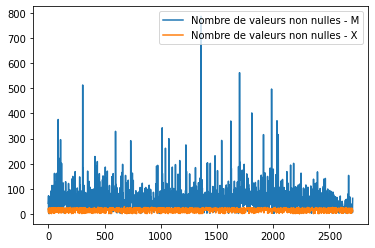

In [ ]:
# Construction de la matrice des degrés D
D = np.diag(np.sum(data_cora['matrice_adjacence'], axis=1))
D_inv = np.diag(  1/np.diag(D)  )

# Construction de la matrice M
M = np.matmul(  np.matmul(D_inv, data_cora['matrice_adjacence'])  ,  data_cora['X']  )

print(M, '\n')

plt.plot(M.index, np.count_nonzero(M, axis=1), label="Nombre de valeurs non nulles - M")
plt.plot(M.index, np.count_nonzero(data_cora['X'], axis=1), label="Nombre de valeurs non nulles - X")
plt.legend();

Au vu des calculs, chaque individu de la matrice M correspond à une transformation de l'individu du même index de la matrice X. On voit de plus que cette transformation réduit drastiquement la sparsité de la matrice de départ.

In [ ]:
train_X, test_X, train_X_lab, test_X_lab = train_test_split(M, data_cora['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_X.shape)
print("Dimension des données de test : ", test_X.shape)

Dimension des données d'entrainement :  (1624, 1433)
Dimension des données de test :  (1084, 1433)


In [ ]:
print("------- Random Forest Classifier -------\n")
forest = RandomForestClassifier(random_state=42, n_estimators=300).fit(train_X, train_X_lab)
forest_scores = print_scores(forest, test_X, test_X_lab)

print("\n----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_X, train_X_lab)
lr_scores = print_scores(lr, test_X, test_X_lab)

print("\n------------ XGB Classifier ------------\n")
xgb_clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 50).fit(train_X, train_X_lab)
xgb_clf_scores = print_scores(xgb_clf, test_X, test_X_lab)

------- Random Forest Classifier -------

Accuracy  : 0.829
F1 score  : 0.829
NMI score : 0.641

----- Logistic Regression Classifier -----

Accuracy  : 0.834
F1 score  : 0.83
NMI score : 0.634

------------ XGB Classifier ------------

Accuracy  : 0.804
F1 score  : 0.792
NMI score : 0.587


On voit que les résultats sont meilleurs lorsqu'on combine les deux matrices.

In [ ]:
param_grid = {'C': np.logspace(-3, 3, 10),
              "fit_intercept": [True, False],
              "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

best_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid, cv=4)
best_lr = best_lr.fit(train_X, train_X_lab)

print(best_lr.best_params_)

lr_scores = print_scores(best_lr, test_X, test_X_lab)

{'C': 2.154434690031882, 'fit_intercept': True, 'solver': 'sag'}
Accuracy  : 0.857
F1 score  : 0.851
NMI score : 0.678


### Dataset Pubmed

#### Uniquement avec la matrice X

Au vu de la taille des données, il nous est ici moins facile de faire plusieurs test ou de jouer avec les paramètres, moins encore d'utiliser des méthodes consommatrices comme le XGB. <br>
Alors on se propose d'effectuer préalablement une réduction de dimension pour faciliter l'étude. 

Notre objectif ici est de reduire suffisament la dimension des données pour  pouvoir appliquer nos algorithmes de classification mais également garder le plus d'information dans l'espace reduite pour distinguer au mieux les classes. Pour ce faire, nous effectuons une ACP sur la matrice X et gardons les premières composantes qui renferment au moins 80% de l'information contenue dans la matrice X

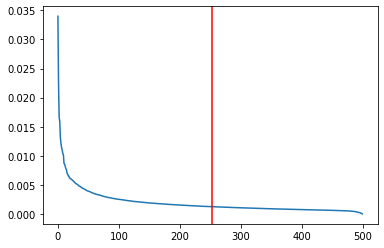

In [ ]:
pca = PCA()
X_reduced_pca = pca.fit_transform(data_pubmed['X'])
y = pca.explained_variance_ratio_

n_composantes_pca = np.where(np.cumsum(y) > 0.80)[0][0]
x_composantes = np.arange(data_pubmed['X'].shape[1])

plt.plot(x_composantes, y)
plt.axvline(n_composantes_pca, color="red", label=f"Composante {n_composantes_pca}")
plt.show()

In [ ]:
X_reduced = PCA(n_components=n_composantes_pca, whiten=False, random_state=42).fit_transform(data_pubmed['X'])

On divise la matrice X en 60% de données d'entrainement et 40% de données de test.

In [ ]:
train_X, test_X, train_X_lab, test_X_lab = train_test_split(X_reduced, data_pubmed['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_X.shape)
print("Dimension des données de test : ", test_X.shape)

Dimension des données d'entrainement :  (11830, 252)
Dimension des données de test :  (7887, 252)


In [ ]:
dtree = DecisionTreeClassifier(random_state=42).fit(train_X, train_X_lab)
dtree_scores = print_scores(dtree, test_X, test_X_lab)

Accuracy  : 0.724
F1 score  : 0.728
NMI score : 0.3


In [ ]:
forest = RandomForestClassifier(random_state=42, n_estimators=300).fit(train_X, train_X_lab)
forest_scores = print_scores(forest, test_X, test_X_lab)

Accuracy  : 0.828
F1 score  : 0.831
NMI score : 0.481


In [ ]:
print("----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_X, train_X_lab)
lr_scores = print_scores(lr, test_X, test_X_lab)

print("\n------------ XGB Classifier ------------\n")
xgb_clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 50).fit(train_X, train_X_lab)
xgb_clf_scores = print_scores(xgb_clf, test_X, test_X_lab)

print("\n--------- AdaBoost Classifier ----------\n")
ada = AdaBoostClassifier(learning_rate = 0.1, random_state=42, n_estimators=200).fit(train_X, train_X_lab)
ada_scores = print_scores(ada, test_X, test_X_lab)

----- Logistic Regression Classifier -----

Accuracy  : 0.859
F1 score  : 0.854
NMI score : 0.681

------------ XGB Classifier ------------

Accuracy  : 0.827
F1 score  : 0.825
NMI score : 0.62

--------- AdaBoost Classifier ----------

Accuracy  : 0.612
F1 score  : 0.54
NMI score : 0.422


#### Avec les informations W et X

Comme pour la partie précédente, on se propose d'appliquer une ACP cette fois ci à la matrice regroupant les informations de X et de W 

In [ ]:
# Construction de la matrice des degrés D
D_inv = np.diag(1 / np.sum(data_pubmed['matrice_adjacence'], axis=1))

# Construction de la matrice M
M = np.matmul(  D_inv, np.matmul(data_pubmed['matrice_adjacence'],  data_pubmed['X'])  )

print(M)

            0         1         2    3    ...       496       497  498  499
0      0.000000  0.005431  0.001232  0.0  ...  0.000000  0.000000  0.0  0.0
1      0.000000  0.000000  0.022060  0.0  ...  0.000000  0.047799  0.0  0.0
2      0.053715  0.000000  0.016293  0.0  ...  0.000000  0.000000  0.0  0.0
3      0.000000  0.000000  0.000000  0.0  ...  0.221053  0.000000  0.0  0.0
4      0.010735  0.000000  0.026880  0.0  ...  0.000000  0.000000  0.0  0.0
...         ...       ...       ...  ...  ...       ...       ...  ...  ...
19712  0.000000  0.000000  0.000000  0.0  ...  0.000000  0.000000  0.0  0.0
19713  0.097250  0.000000  0.026090  0.0  ...  0.000000  0.000000  0.0  0.0
19714  0.000000  0.000000  0.000000  0.0  ...  0.000000  0.000000  0.0  0.0
19715  0.128586  0.000000  0.000000  0.0  ...  0.000000  0.000000  0.0  0.0
19716  0.000000  0.000000  0.000000  0.0  ...  0.000000  0.000000  0.0  0.0

[19717 rows x 500 columns]


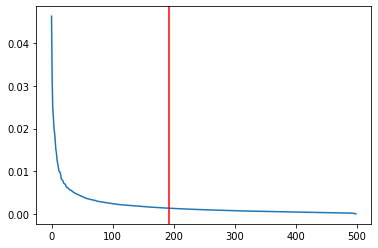

In [ ]:
pca = PCA()
X_reduced_pca = pca.fit_transform(M)
y = pca.explained_variance_ratio_

n_composantes_pca = np.where(np.cumsum(y) > 0.80)[0][0]
x_composantes = np.arange(M.shape[1])

plt.plot(x_composantes, y)
plt.axvline(n_composantes_pca, color="red", label=f"Composante {n_composantes_pca}")
plt.show()

In [ ]:
X_reduced = PCA(n_components=n_composantes_pca, whiten=False, random_state=42).fit_transform(data_pubmed['X'])

train_X, test_X, train_X_lab, test_X_lab = train_test_split(X_reduced, data_pubmed['labels'].loc[:, 0], test_size=0.4)

print("Dimension des données d'entrainement : ", train_X.shape)
print("Dimension des données de test : ", test_X.shape)

Dimension des données d'entrainement :  (11830, 192)
Dimension des données de test :  (7887, 192)


In [ ]:
forest = RandomForestClassifier(random_state=42, n_estimators=300).fit(train_X, train_X_lab)
forest_scores = print_scores(forest, test_X, test_X_lab)

Accuracy  : 0.833
F1 score  : 0.835
NMI score : 0.488


In [ ]:
print("----- Logistic Regression Classifier -----\n")
lr = LogisticRegression(random_state=42).fit(train_X, train_X_lab)
lr_scores = print_scores(lr, test_X, test_X_lab)

print("\n------------ XGB Classifier ------------\n")
xgb_clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 50).fit(train_X, train_X_lab)
xgb_clf_scores = print_scores(xgb_clf, test_X, test_X_lab)

print("\n--------- AdaBoost Classifier ----------\n")
ada = AdaBoostClassifier(learning_rate = 0.1, random_state=42, n_estimators=200).fit(train_X, train_X_lab)
ada_scores = print_scores(ada, test_X, test_X_lab)

----- Logistic Regression Classifier -----

Accuracy  : 0.845
F1 score  : 0.845
NMI score : 0.509

------------ XGB Classifier ------------

Accuracy  : 0.843
F1 score  : 0.845
NMI score : 0.509

--------- AdaBoost Classifier ----------

Accuracy  : 0.774
F1 score  : 0.782
NMI score : 0.39


Les résultats sont globalement meilleurs que lors de l'utilisation simple de X.

## Etude comparative

#### Meilleurs résultats



Dataset Citiseer

* Matrice : X 
* Algorithme : Forêt aléatoire avec 500 estimateurs 
* Métriques : Accuracy = 0.721, F1 score = 0.674 et NMI score = 0.432



Dataset Cora

* Matrice : M 
* Algorithme : Régression logistique avec les paramètres *C* = 2.15,  *fit_intercept* = True et *solver* = 'sag'
* Métriques : Accuracy = 0.857, F1 score = 0.851 et NMI score = 0.678


Dataset Pubmed

* Matrice : X 
* Algorithme : Régression logistique
* Métriques : Accuracy = 0.859, F1 score = 0.854 et NMI score = 0.681


#### Comparaison des classifieurs

Sur les trois données à notre disposition, les méthodes de régression logistique et de forêts aléatoires donnent les meilleurs résultats presque à chaque fois. Toutes les méthodes donnent des résultats plutôt différents selon la sparsité des données. Nous avons également pu observer l'instabilité des arbres de décision, l'ineficacité du KNN lorsque les données sont de très grandes dimensions et la rapidité de la regression logistique en terme de complexité algorithmique.

In [27]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/M2_MLSD/Apprentissage_supervise/Projet_final.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
texlive-xetex is already the newest version (2017.20180305-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  c